In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [3]:
# Compute the Mott-Massey results
mm = LocalSystem(1.5)
mm_vtilde = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)
mm_evals, mm_evecs = bind.bound_states(mm_vtilde, 0, 0, mm.q, mm.wq)

In [4]:
def ftr(state, r, q, wq):
    y = np.array([np.sum(np.sqrt(2/np.pi) * wq * q**2 * state * spherical_jn(0, q*ri)) for ri in r])
    return 1/np.sqrt(np.sum(ls.r_weights * ls.r_nodes**2 * y**2)) * y


def local_LO_counterterm(r, R):
    return np.exp(-(r/R)**4)


def psi0(ls, g, ii, full=False):
    evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)
    psi0 = np.zeros(7)
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
        if full:
            psi0[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_NLO_counterterm(ls.r_nodes, Ri) * psi**2)
        else:
            psi0[i] = psi[ii]**2
    return psi0


def psi_Vnlo_psi(evals, evecs, R):
    overlap = np.zeros(7)
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
        overlap[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_LO_counterterm(ls.r_nodes, R) * psi**2)
    return overlap


def evals_and_evecs(g, ls):
    return bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)


def f_root(theta, ls):
    glo, gnlo = theta
    evals, evecs = evals_and_evecs(glo, ls)
    evals = evals[np.where(np.abs(evals) > 1e-9)[0]]
    assert evals.size == 7, f'There are {evals.size} bounds states.'
    
    overlap = psi_Vnlo_psi(evals, evecs, ls.r_c)
#     return np.linalg.norm(mm_evals[-2:] - (evals[-2:] + c2*overlap[-2:]))
    return (mm_evals[5:] - evals[5:]*(1 + gnlo*overlap[5:])) / mm_evals[5:]

In [5]:
Rs, gs = np.loadtxt('rgflow_local_lo_B6_fix.txt', unpack=True)

In [6]:
Ri = Rs[0]
gi = gs[0]
ls = LocalSystem(Ri, nq=250)
evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(gi, 0), 1, ls.q, ls.wq)

In [7]:
guess = np.array([1.01*gi, 0.05])
f_root(guess, ls)

array([ 0.04700206, -0.12497342])

In [8]:
class Spectrum:
    def __init__(self, ls, glo, gnlo):
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(glo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.glo = glo
        self.g_nlo = gnlo
        
        self.overlap = psi_Vnlo_psi(self.lo_evals, self.lo_evecs, self.R)
        self.nlo_evals = self.lo_evals + self.g_nlo*self.lo_evals*self.overlap

In [9]:
optimize.fsolve(f_root, guess, args=(ls))

array([-0.05051796,  0.51947456])

In [10]:
glos = np.zeros(Rs.size)
gnlos = np.zeros(Rs.size)
specs = []
for (i, (Ri, gi)) in enumerate(zip(Rs, gs)):
    ls = LocalSystem(Ri, nq=200)
    result = optimize.fsolve(f_root, guess, args=(ls), xtol=1e-10)
    glo, gnlo = result
    
    glos[i] = glo
    gnlos[i] = gnlo
    specs.append(Spectrum(ls, glo, gnlo))
    
    print(f'i = {i}  R = {Ri:.4e}  g_lo = {glo:.4e}  g_nlo = {gnlo:.4e}')
    if i == Rs.size-1:
        break
    
    if i < 5:
        guess = result
    else:
        glo_curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
        gnlo_curve = interp1d(Rs[i-5:i], gnlos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = np.array([glo_curve(Rs[i+1]), gnlo_curve(Rs[i+1])])
        except:
            print('Did not get a good guess.')
            break

i = 0  R = 3.2710e+00  g_lo = -5.0503e-02  g_nlo = 6.1251e-01
i = 1  R = 3.0823e+00  g_lo = -5.3824e-02  g_nlo = 4.9356e-01
i = 2  R = 2.9142e+00  g_lo = -5.6517e-02  g_nlo = 2.6784e-01
i = 3  R = 2.7634e+00  g_lo = -5.8473e-02  g_nlo = 9.6825e-02
i = 4  R = 2.6275e+00  g_lo = -5.9881e-02  g_nlo = 3.3645e-02
i = 5  R = 2.5044e+00  g_lo = -6.0945e-02  g_nlo = 3.6635e-02
i = 6  R = 2.3922e+00  g_lo = -6.1652e-02  g_nlo = 3.9369e-02
i = 7  R = 2.2897e+00  g_lo = -6.1844e-02  g_nlo = 1.5944e-02
i = 8  R = 2.1956e+00  g_lo = -6.1379e-02  g_nlo = -2.5633e-02
i = 9  R = 2.1089e+00  g_lo = -6.0215e-02  g_nlo = -6.5898e-02
i = 10  R = 2.0288e+00  g_lo = -5.8399e-02  g_nlo = -9.3489e-02
i = 11  R = 1.9546e+00  g_lo = -5.5986e-02  g_nlo = -1.0992e-01
i = 12  R = 1.8856e+00  g_lo = -5.2990e-02  g_nlo = -1.2312e-01
i = 13  R = 1.8213e+00  g_lo = -4.9406e-02  g_nlo = -1.3588e-01
i = 14  R = 1.7613e+00  g_lo = -4.5242e-02  g_nlo = -1.4748e-01
i = 15  R = 1.7051e+00  g_lo = -4.0541e-02  g_nlo = -1.549

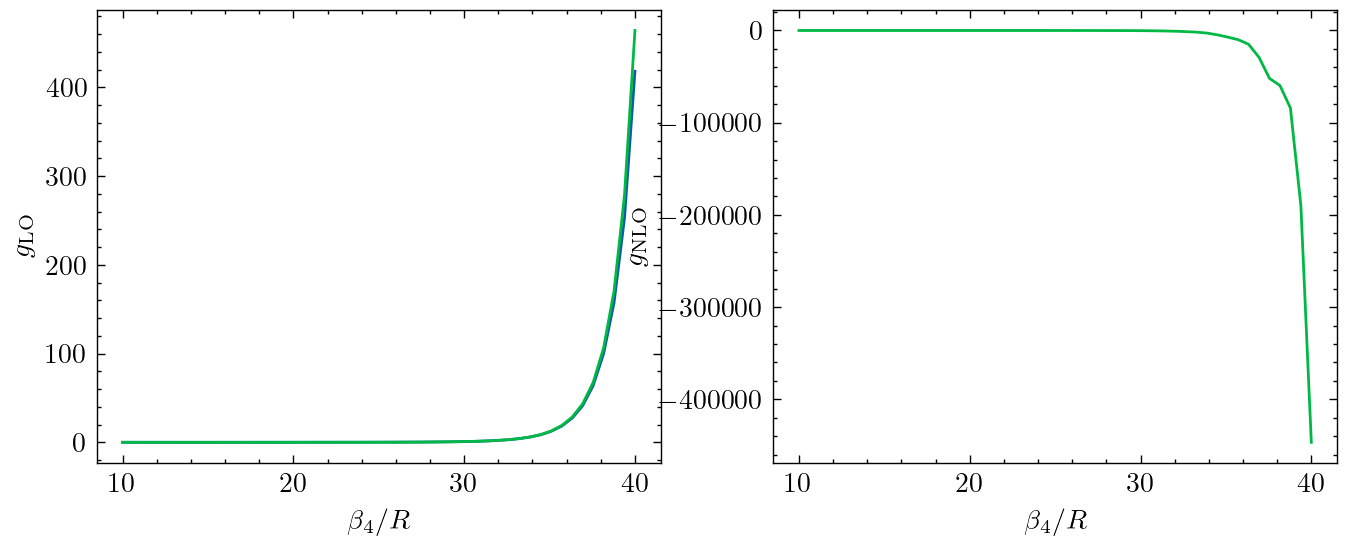

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(2*gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax[0].plot(const.BETA4/Rs, glos)
ax[0].plot(const.BETA4/Rs, gs)
ax[1].plot(const.BETA4/Rs, gnlos, color='C1')

# ax.set_ylim([-1, 1])
ax[0].set_xlabel(r'$\beta_4/R$')
ax[0].set_ylabel(r'$g_{\rm LO}$')
ax[1].set_xlabel(r'$\beta_4/R$')
ax[1].set_ylabel(r'$g_{\rm NLO}$');

In [12]:
np.savetxt('rgflow_local_nlo_B5_B6_fix.txt', np.vstack((Rs, glos, gnlos)).T, header='R  g_LO  g_NLO')

In [13]:
lo_results = np.loadtxt('spectra_local_lo_B6_fix.txt')

In [14]:
# lo_specs = np.array([spec.lo_evals for spec in specs])
nlo_specs = np.array([spec.nlo_evals  for spec in specs])

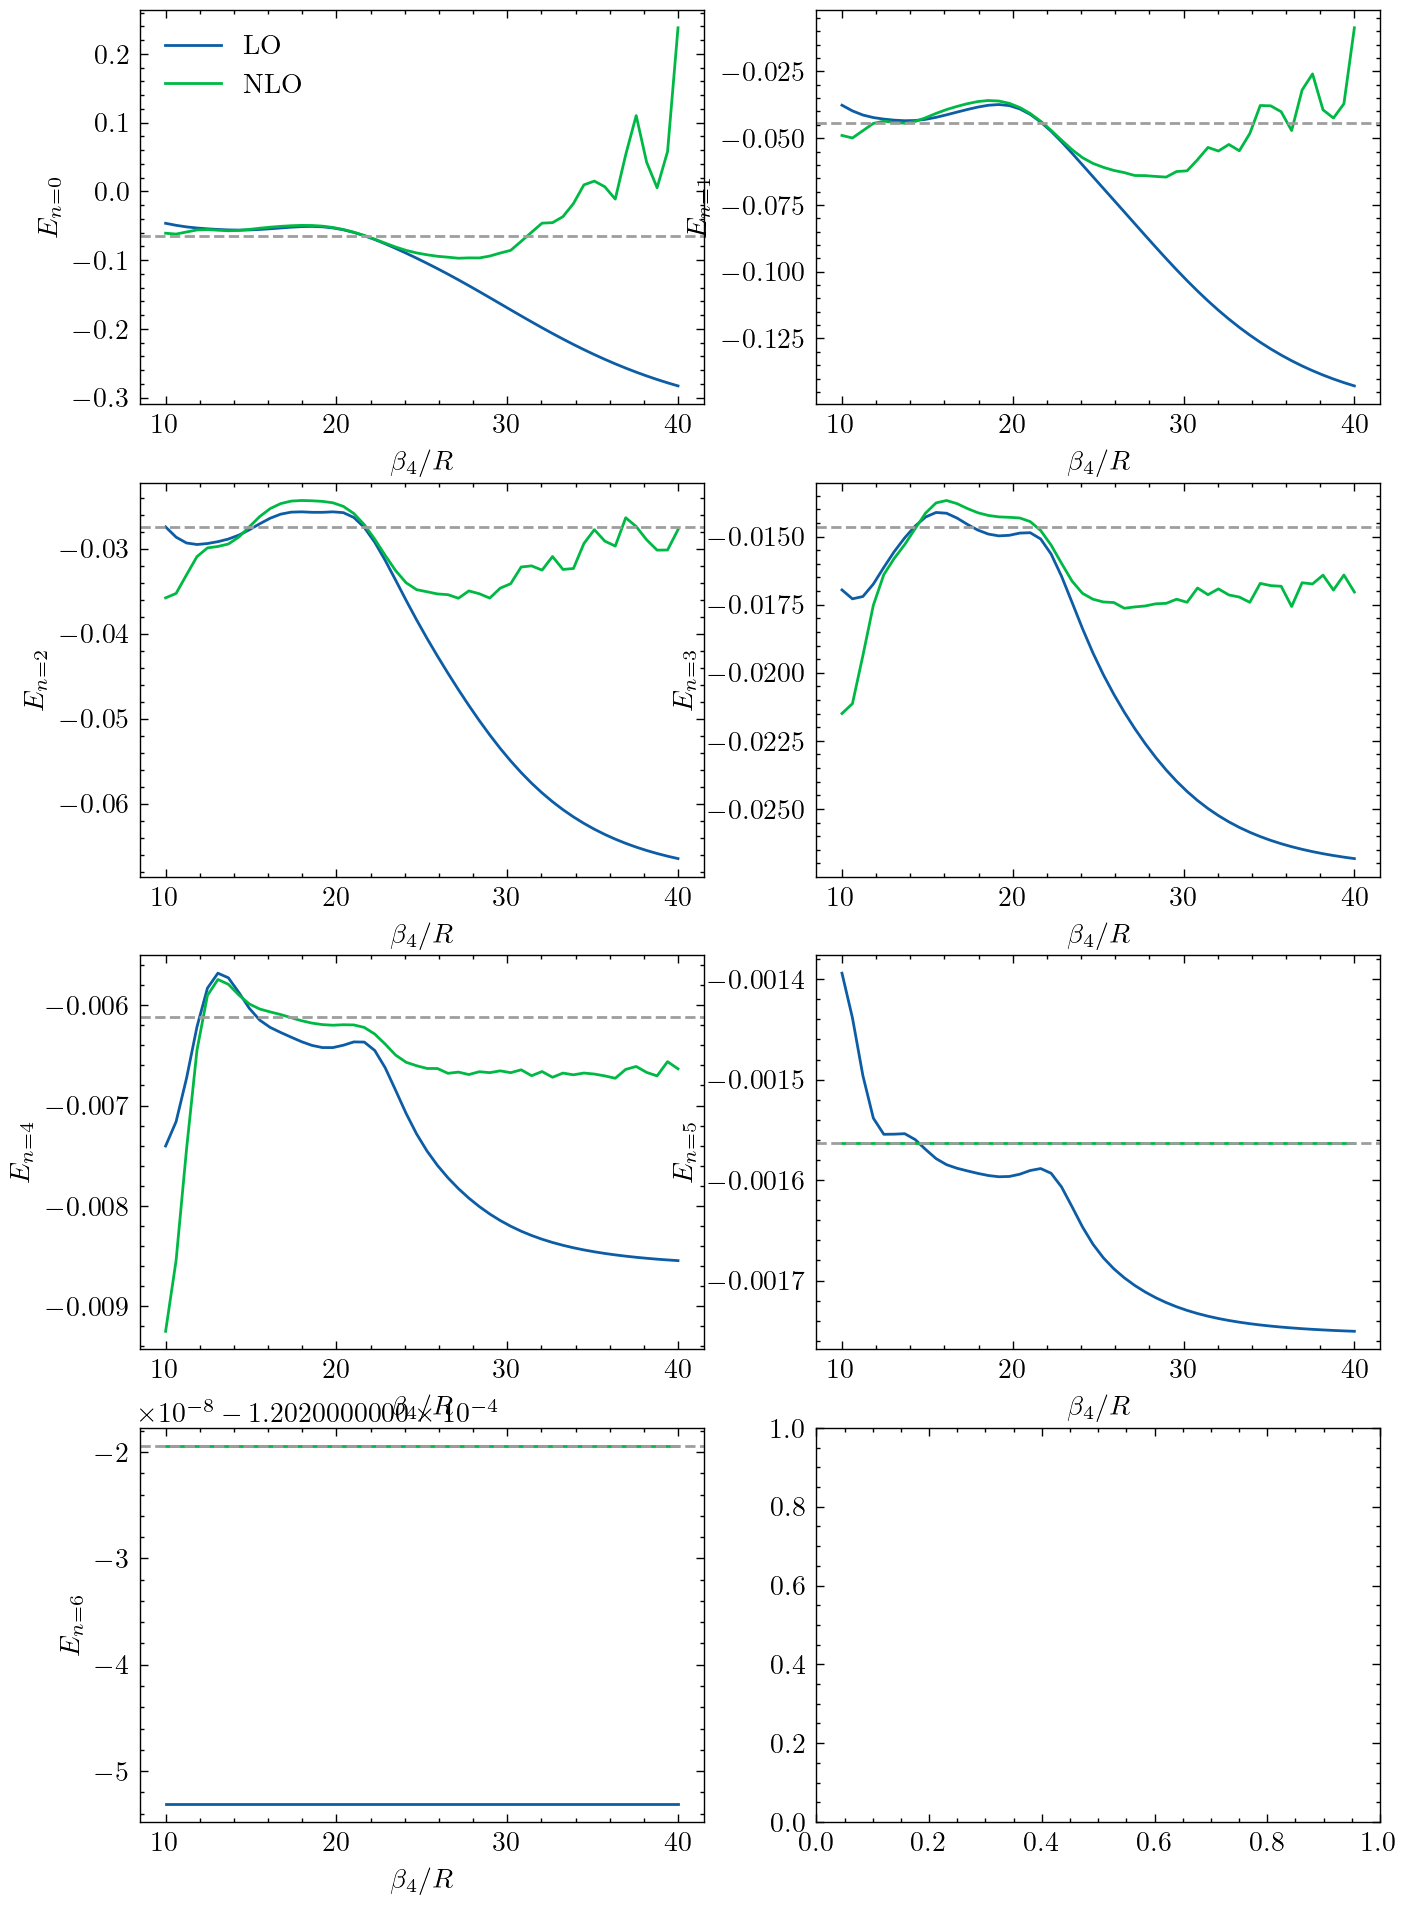

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/lo_results[:, 0], lo_results[:, i+1], label=r'LO')
    ax[i//2, i%2].plot(const.BETA4/Rs, nlo_specs[:, i], label=r'NLO')
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i))
    if i == 0:
        ax[0, 0].legend()

In [16]:
all_overlaps = np.array([spec.overlap for spec in specs])

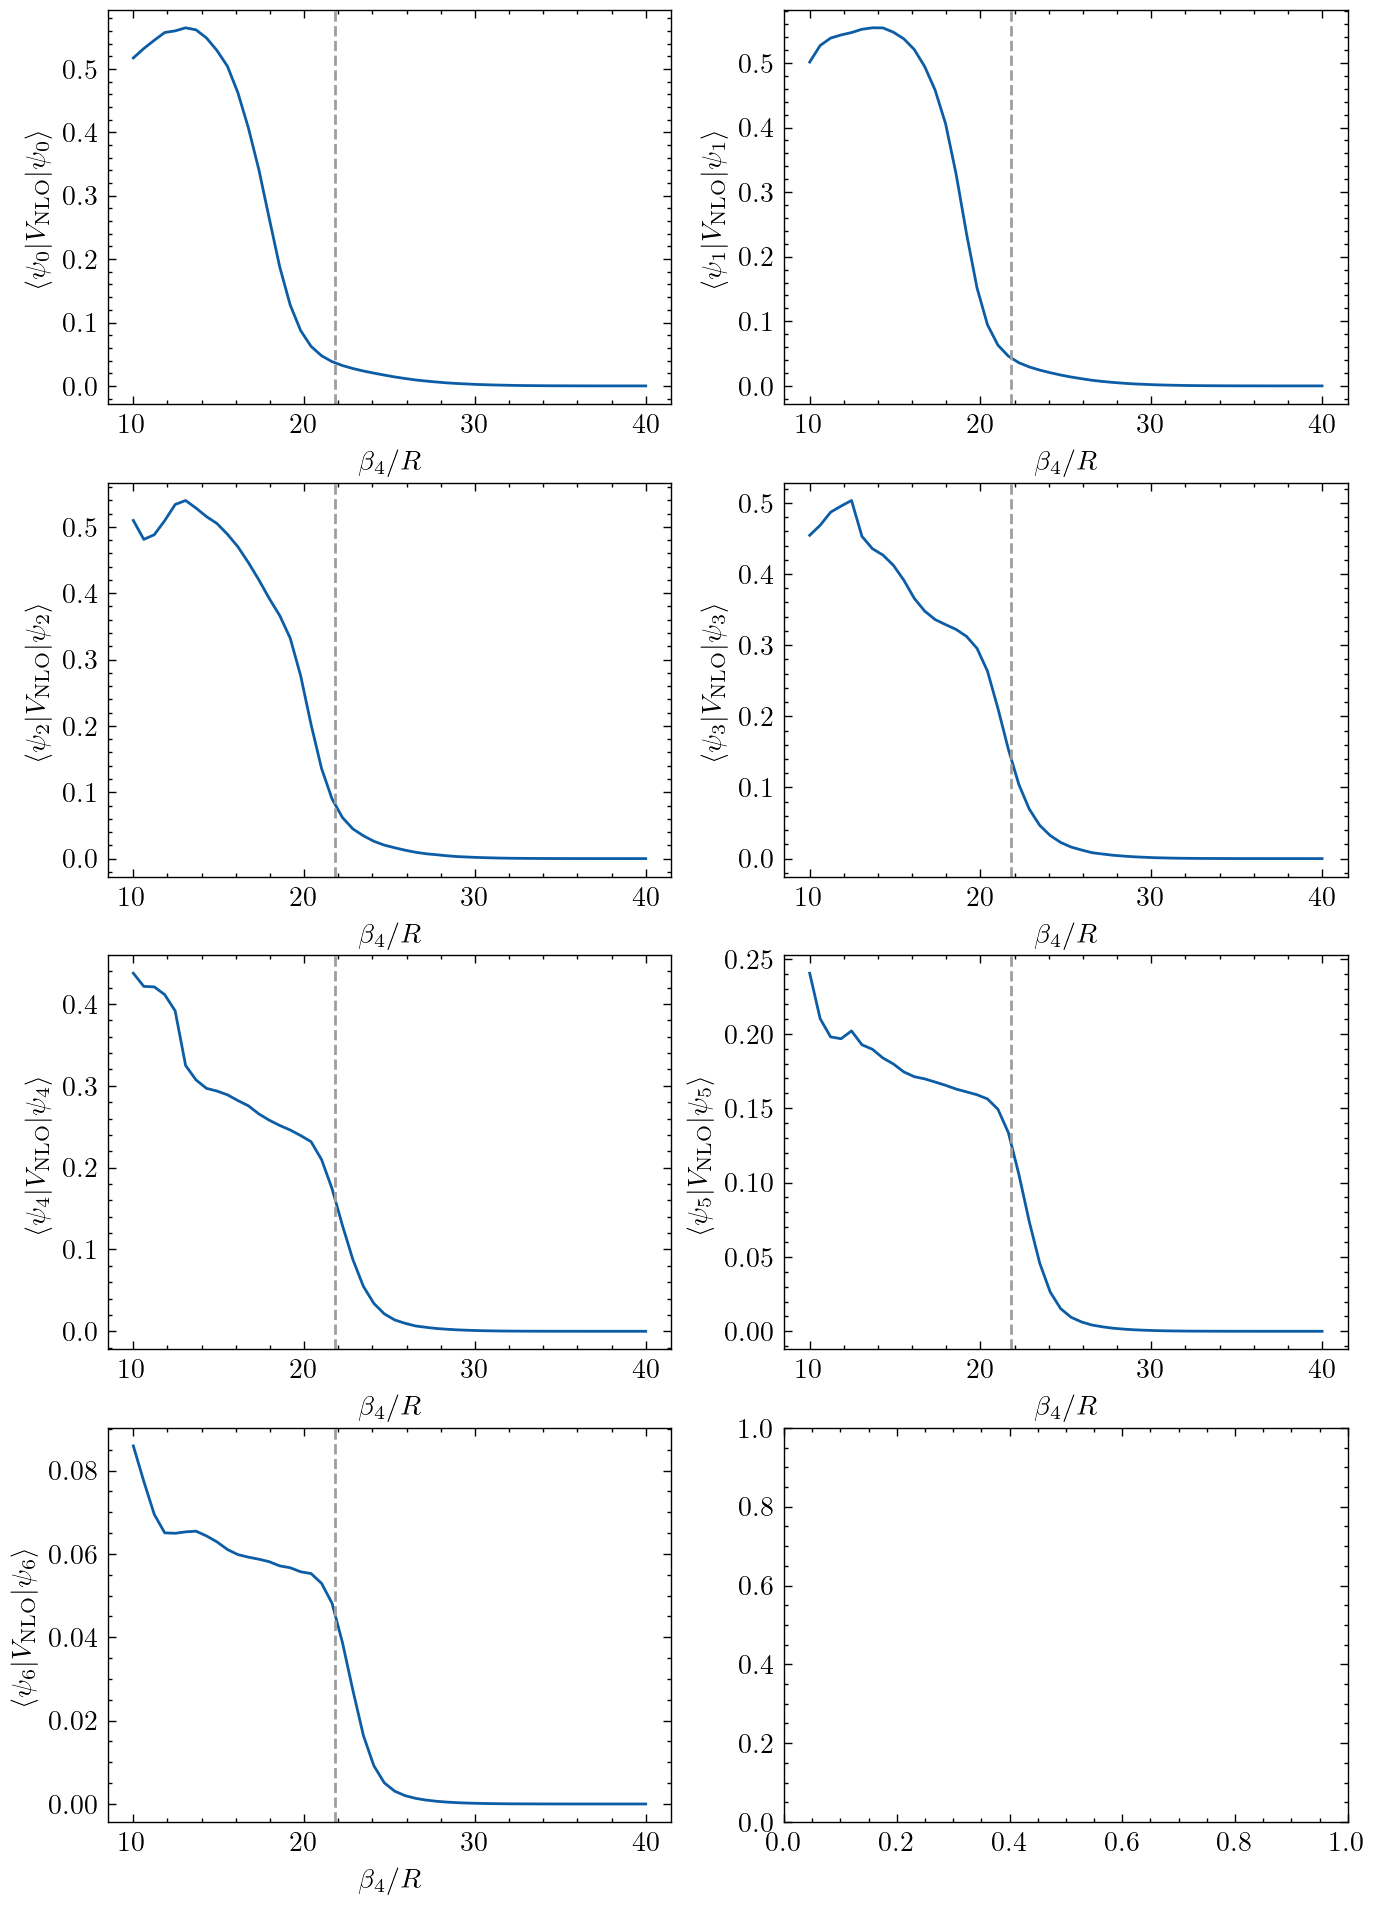

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, all_overlaps[:, i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$\langle\psi_{%d}|V_{\rm NLO}|\psi_{%d}\rangle$' % (i, i))
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

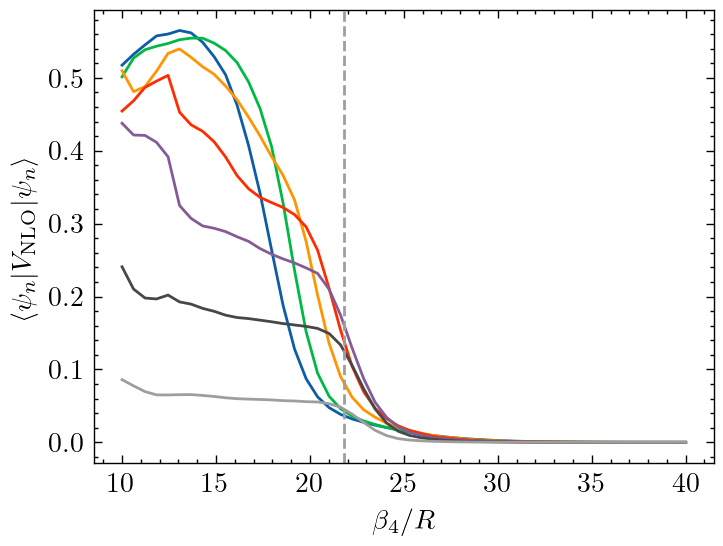

In [18]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs, all_overlaps[:, i])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$\langle\psi_{n}|V_{\rm NLO}|\psi_{n}\rangle$')
ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')

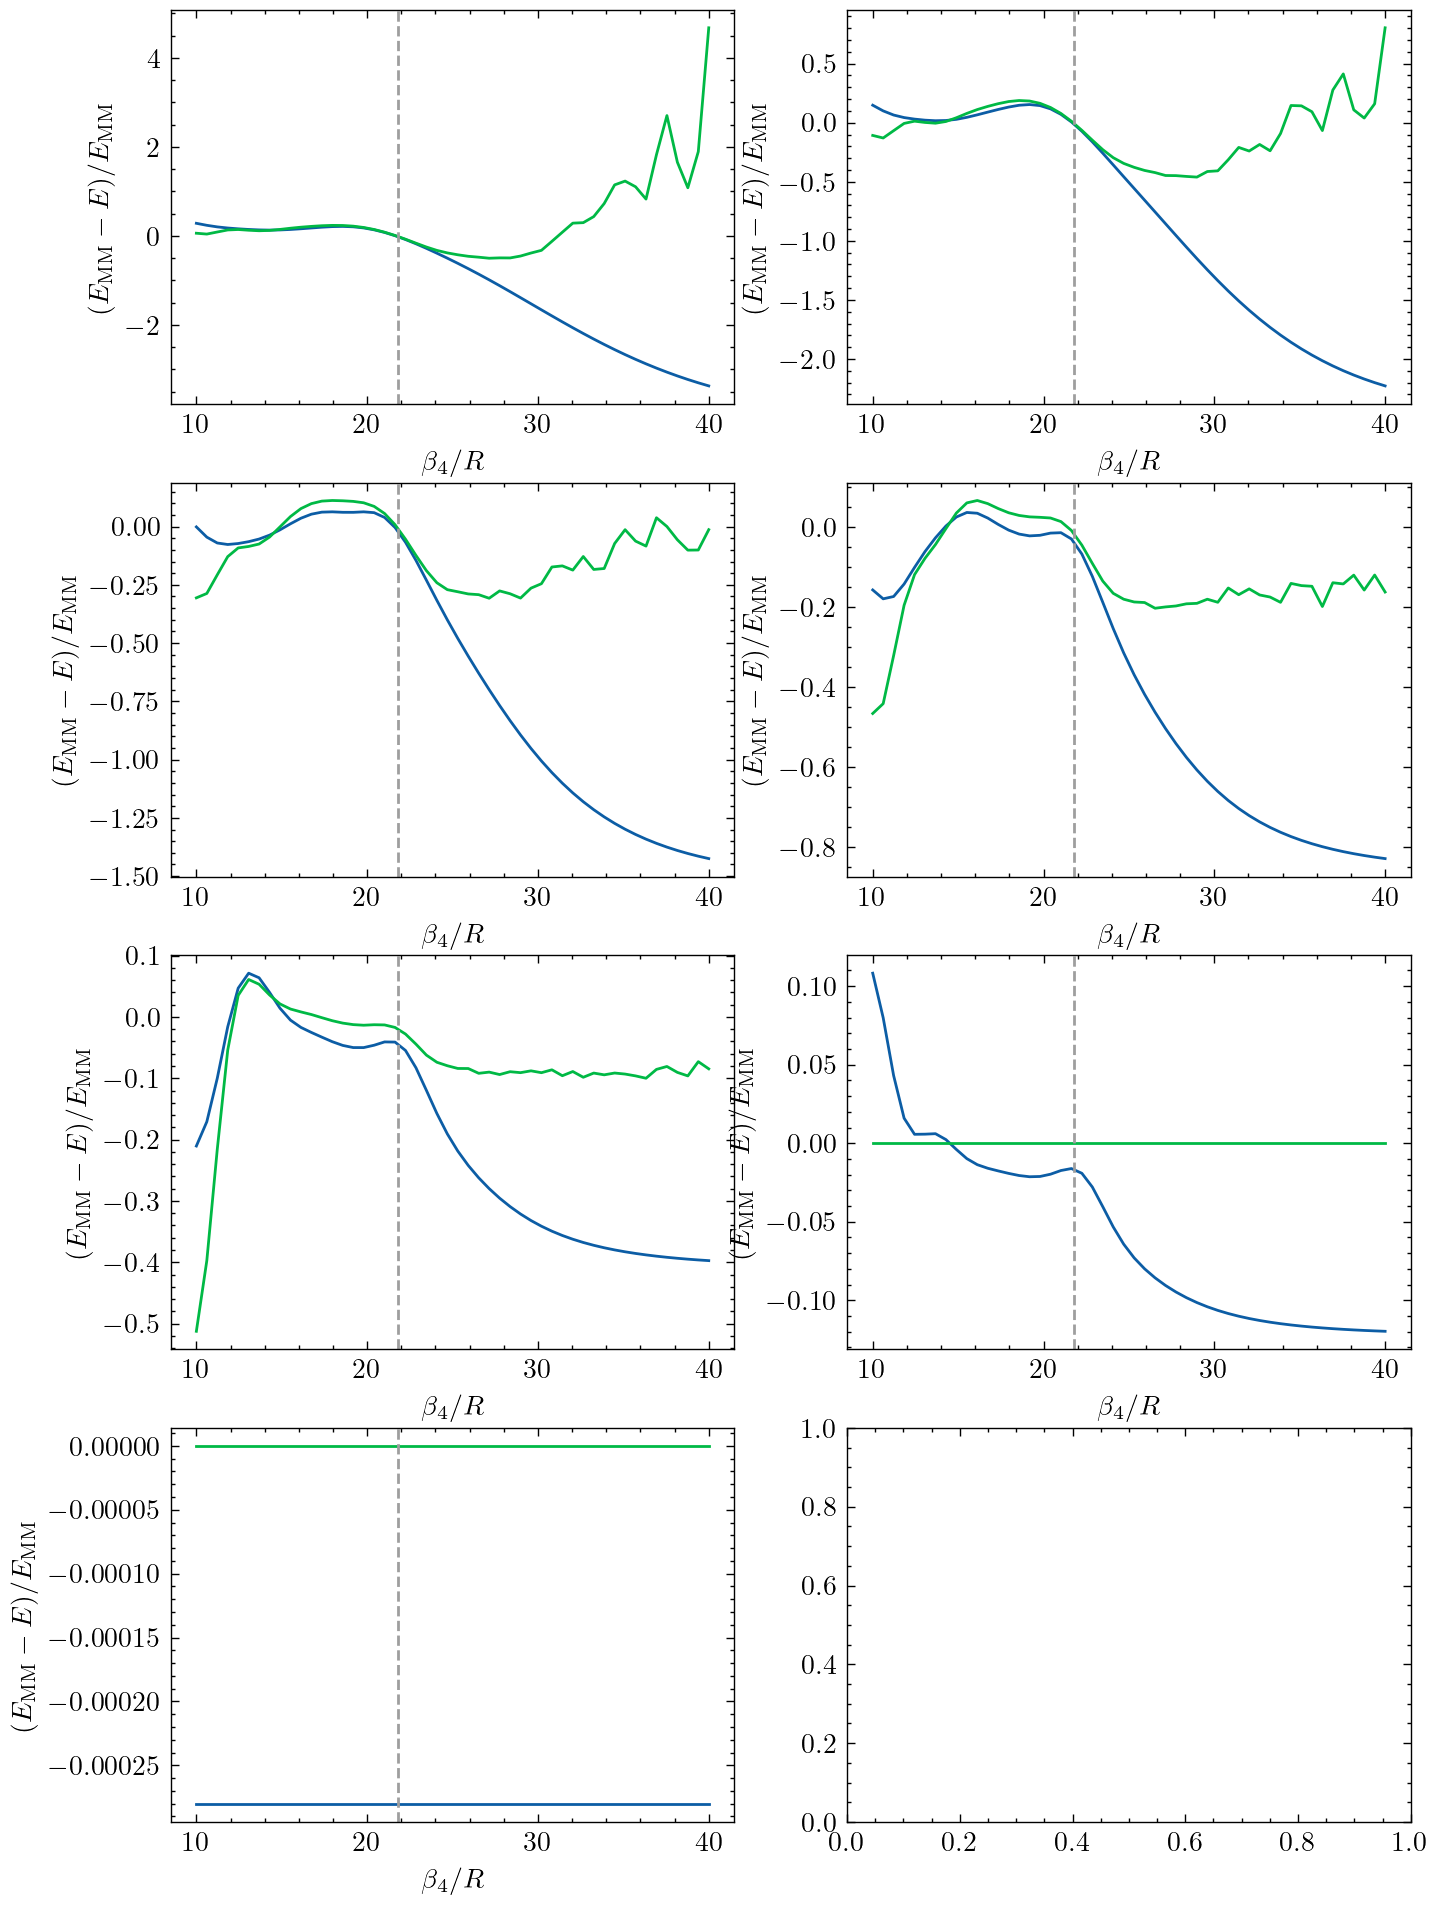

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/lo_results[:, 0], (mm_evals[i] - lo_results[:, i+1])/mm_evals[i])
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - nlo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

In [20]:
np.savetxt('spectra_local_nlo_B5_B6_fix.txt', np.vstack((Rs, nlo_specs.T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6')

In [21]:
np.savetxt('spectra_Mott_Massey.txt', mm_evals)